In [14]:
import sys
sys.path.append('../smoothquant')
from fake_quant import *
from smooth import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import torch
import torch.nn as nn
from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    LlamaDecoderLayer,
    LlamaForCausalLM,
    LlamaMLP,
)
from transformers import LlamaTokenizer
from smoothquant.smooth import smooth_lm
from smoothquant.fake_quant import quantize_llama_like
import tqdm

In [2]:
from datasets import load_dataset

tokenizer = LlamaTokenizer.from_pretrained("../../llama-2-7b-hf")
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [3]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "../../llama-2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
print(model_fp16)



LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
        (self_attn): LlamaAtten

In [21]:
sample1 = dataset[4]["text"]  # 使用固定的第一個樣本
print("\nSample text:", sample1)


Sample text:  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode of the television series , Doctors , followed by a role in the 2007 theatre production of How to Curse directed by Josie Rourke . How to Curse was performed at Bush Theatre in the London Borough of Hammersmith and Fulham . Boulter starred in two films in 2008 , Daylight Robbery by filmmaker Paris Leonti , and Donkey Punch directed by Olly Blackburn . In May 2008 , Boulter made a guest appearance on a two @-@ part episode arc of the television series Waking the Dead , followed by an appearance on the television series Survivors in November 2008 . He had a recurring role in ten episodes of the television series Casualty in 2010 , as " Kieron Fletcher " . Boulter starred in the 2011 film Mercenaries directed by Paris Leonti . 



In [5]:
import functools
def get_residual_scales(model):
    model.eval()
    residual_scales_all = {}
    
    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        tensor_original = tensor.clone().view(-1, hidden_dim).detach()
        residual_scales_all[name] = tensor_original

    def decoder_layer_hook(module, input, output, layer_idx):
        # 在這裡，input 是一個 tensor（hidden_states）
        if isinstance(input, tuple):
            hidden_states = input[0]
        else:
            hidden_states = input
            
        # 收集 self-attention 的 residual
        stat_tensor(f"layer_{layer_idx}_attn_residual", hidden_states)
        
        # 收集 MLP 的 residual（就是 self-attention 的輸出）
        if isinstance(output, tuple):
            mlp_residual = output[0]
        else:
            mlp_residual = output
        stat_tensor(f"layer_{layer_idx}_mlp_residual", mlp_residual)

    hooks = []
    
    # 為每個 decoder layer 註冊 hook
    for i, (name, module) in enumerate(model.named_modules()):
        if isinstance(module, LlamaDecoderLayer):
            layer_idx = name.split('.')[-1]
            print(f"Registering hook for decoder layer: {name}")
            hook = module.register_forward_hook(
                functools.partial(decoder_layer_hook, layer_idx=layer_idx)
            )
            hooks.append(hook)
    
    # 使用固定的輸入
    tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    sample = dataset[4]["text"]  # 使用固定的第一個樣本
    print("\nSample text:", sample)
    
    input_ids = tokenizer(sample, return_tensors="pt", truncation=True, max_length=1024).input_ids
    input_ids = input_ids.to(model.device)
    
    # 執行前向傳遞
    with torch.no_grad():
        outputs = model(input_ids)
    
    # 移除所有 hooks
    for hook in hooks:
        hook.remove()
    
    # 印出收集到的資訊
    print("\n收集到的層的資訊:")
    for name in sorted(residual_scales_all.keys()):
        tensor = residual_scales_all[name]
        print(f"\n層名稱: {name}")
        print(f"Tensor 形狀: {tensor.shape}")
        print(f"均值: {tensor.mean().item():.4f}")
        print(f"標準差: {tensor.std().item():.4f}")
        print(f"最大值: {tensor.max().item():.4f}")
        print(f"最小值: {tensor.min().item():.4f}")
    
    return residual_scales_all



## FP16

In [22]:
# 執行
residual_scales = get_residual_scales(model_fp16)

Registering hook for decoder layer: model.layers.0
Registering hook for decoder layer: model.layers.1
Registering hook for decoder layer: model.layers.2
Registering hook for decoder layer: model.layers.3
Registering hook for decoder layer: model.layers.4
Registering hook for decoder layer: model.layers.5
Registering hook for decoder layer: model.layers.6
Registering hook for decoder layer: model.layers.7
Registering hook for decoder layer: model.layers.8
Registering hook for decoder layer: model.layers.9
Registering hook for decoder layer: model.layers.10
Registering hook for decoder layer: model.layers.11
Registering hook for decoder layer: model.layers.12
Registering hook for decoder layer: model.layers.13
Registering hook for decoder layer: model.layers.14
Registering hook for decoder layer: model.layers.15
Registering hook for decoder layer: model.layers.16
Registering hook for decoder layer: model.layers.17
Registering hook for decoder layer: model.layers.18
Registering hook for d

/home/master_112/m56121041/miniconda3/envs/smoothquant/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.



Sample text:  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode of the television series , Doctors , followed by a role in the 2007 theatre production of How to Curse directed by Josie Rourke . How to Curse was performed at Bush Theatre in the London Borough of Hammersmith and Fulham . Boulter starred in two films in 2008 , Daylight Robbery by filmmaker Paris Leonti , and Donkey Punch directed by Olly Blackburn . In May 2008 , Boulter made a guest appearance on a two @-@ part episode arc of the television series Waking the Dead , followed by an appearance on the television series Survivors in November 2008 . He had a recurring role in ten episodes of the television series Casualty in 2010 , as " Kieron Fletcher " . Boulter starred in the 2011 film Mercenaries directed by Paris Leonti . 


收集到的層的資訊:

層名稱: layer_0_attn_residual
Tensor 形狀: torch.Size([249, 4096])
均值: -0.0000
標準差: 0.0130
最大值: 0.1206
最小值: -0.1367



In [25]:
import pickle

def save_residual_scales(residual_scales, file_path="residual_scales.pkl"):
    """
    Save residual scales to a file using pickle.

    Args:
        residual_scales (dict): Dictionary containing the residual scales.
        file_path (str): Path to save the pickle file.
    """
    with open(file_path, "wb") as f:
        pickle.dump(residual_scales, f)
    print(f"Residual scales saved to {file_path}")

save_residual_scales(residual_scales, "residual_scales.pkl")


Residual scales saved to residual_scales.pkl


In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_residual_3d(residual_scales_all, layer_idx, residual_type):
    """
    繪製指定層 residual 的 3D 圖表。
    
    Args:
        residual_scales_all (dict): 收集到的 residual 資料。
        layer_idx (int): 要繪製的層號。
        residual_type (str): 'attn' 或 'mlp'，指定 residual 類型。
    """
    key = f"layer_{layer_idx}_{residual_type}_residual"
    if key not in residual_scales_all:
        print(f"Key {key} not found in residual_scales_all.")
        return

    # 提取 residual 資料
    residual = residual_scales_all[key].cpu().numpy()
    seq_len, hidden_dim = residual.shape

    # 創建 X (token id) 和 Y (hidden_dim) 軸
    X = np.arange(seq_len)  # Token IDs
    Y = np.arange(hidden_dim)  # Hidden Dimensions
    X, Y = np.meshgrid(X, Y)

    # Z 軸 (Residual 值)
    Z = residual.T  # Transpose for compatibility with (Y, X) axes

    # 繪製 3D 圖表
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='k', alpha=0.7)

    # 添加標籤和標題
    ax.set_title(f"Layer {layer_idx} {residual_type.capitalize()} Residual")
    ax.set_xlabel("Token ID")
    ax.set_ylabel("Hidden Dimension")
    ax.set_zlabel("Value")
    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.show()


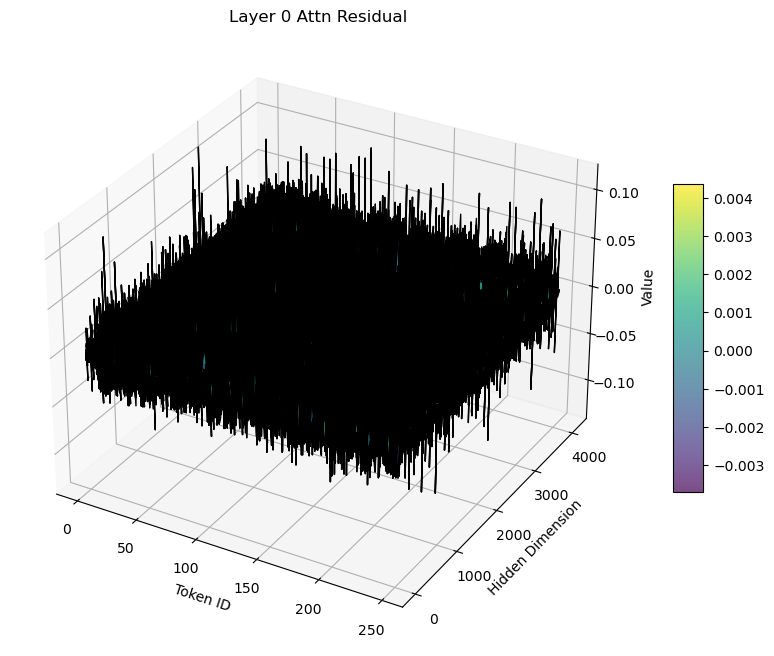

In [24]:
test_layer = 0  # 第一層
test_residual_type = "attn"  # 測試 attention residual
plot_residual_3d(residual_scales, test_layer, test_residual_type)


In [ ]:
def plot_residual_3d_and_save(residual_scales_all, layer_idx, residual_type, save_dir="plots"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    key = f"layer_{layer_idx}_{residual_type}_residual"
    if key not in residual_scales_all:
        print(f"Key {key} not found in residual_scales_all.")
        return

    residual = residual_scales_all[key].cpu().numpy()
    seq_len, hidden_dim = residual.shape
    X = np.arange(seq_len)
    Y = np.arange(hidden_dim)
    X, Y = np.meshgrid(X, Y)
    Z = residual.T

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='k', alpha=0.7)

    ax.set_title(f"Layer {layer_idx} {residual_type.capitalize()} Residual")
    ax.set_xlabel("Token ID")
    ax.set_ylabel("Hidden Dimension")
    ax.set_zlabel("Value")
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Save figure
    file_path = os.path.join(save_dir, f"layer_{layer_idx}_{residual_type}_residual.png")
    plt.savefig(file_path)
    plt.close(fig)
    print(f"Saved plot to {file_path}")

In [26]:


# 保存所有層的圖表
for layer_idx in range(32):
    plot_residual_3d_and_save(residual_scales, layer_idx, "attn")
    plot_residual_3d_and_save(residual_scales, layer_idx, "mlp")


Saved plot to plots/layer_0_attn_residual.png
Saved plot to plots/layer_0_mlp_residual.png
Saved plot to plots/layer_1_attn_residual.png
Saved plot to plots/layer_1_mlp_residual.png
Saved plot to plots/layer_2_attn_residual.png
Saved plot to plots/layer_2_mlp_residual.png
Saved plot to plots/layer_3_attn_residual.png
Saved plot to plots/layer_3_mlp_residual.png
Saved plot to plots/layer_4_attn_residual.png
Saved plot to plots/layer_4_mlp_residual.png
Saved plot to plots/layer_5_attn_residual.png
Saved plot to plots/layer_5_mlp_residual.png
Saved plot to plots/layer_6_attn_residual.png
Saved plot to plots/layer_6_mlp_residual.png
Saved plot to plots/layer_7_attn_residual.png
Saved plot to plots/layer_7_mlp_residual.png
Saved plot to plots/layer_8_attn_residual.png
Saved plot to plots/layer_8_mlp_residual.png
Saved plot to plots/layer_9_attn_residual.png
Saved plot to plots/layer_9_mlp_residual.png
Saved plot to plots/layer_10_attn_residual.png
Saved plot to plots/layer_10_mlp_residual.p

## W4A4

In [9]:
act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm(model_fp16, act_scales, 0.85)

Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=11008, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=11008, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=11008, bias=False), Type: <class 'torch.nn.modules.linea

In [10]:
model_W4A4_all = quantize_llama_like_4bit(model_fp16)
print(model_W4A4_all)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W4A4Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W4A4Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
         

In [11]:
residual_scales_4bit_all = get_residual_scales(model_W4A4_all)

Registering hook for decoder layer: model.layers.0
Registering hook for decoder layer: model.layers.1
Registering hook for decoder layer: model.layers.2
Registering hook for decoder layer: model.layers.3
Registering hook for decoder layer: model.layers.4
Registering hook for decoder layer: model.layers.5
Registering hook for decoder layer: model.layers.6
Registering hook for decoder layer: model.layers.7
Registering hook for decoder layer: model.layers.8
Registering hook for decoder layer: model.layers.9
Registering hook for decoder layer: model.layers.10
Registering hook for decoder layer: model.layers.11
Registering hook for decoder layer: model.layers.12
Registering hook for decoder layer: model.layers.13
Registering hook for decoder layer: model.layers.14
Registering hook for decoder layer: model.layers.15
Registering hook for decoder layer: model.layers.16
Registering hook for decoder layer: model.layers.17
Registering hook for decoder layer: model.layers.18
Registering hook for d

/home/master_112/m56121041/miniconda3/envs/smoothquant/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.



Sample text:  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He appeared on a 2006 episode of the television series , Doctors , followed by a role in the 2007 theatre production of How to Curse directed by Josie Rourke . How to Curse was performed at Bush Theatre in the London Borough of Hammersmith and Fulham . Boulter starred in two films in 2008 , Daylight Robbery by filmmaker Paris Leonti , and Donkey Punch directed by Olly Blackburn . In May 2008 , Boulter made a guest appearance on a two @-@ part episode arc of the television series Waking the Dead , followed by an appearance on the television series Survivors in November 2008 . He had a recurring role in ten episodes of the television series Casualty in 2010 , as " Kieron Fletcher " . Boulter starred in the 2011 film Mercenaries directed by Paris Leonti . 


收集到的層的資訊:

層名稱: layer_0_attn_residual
Tensor 形狀: torch.Size([249, 4096])
均值: -0.0000
標準差: 0.0130
最大值: 0.1206
最小值: -0.1367



In [12]:
def plot_residual_3d_and_save(residual_scales_all, layer_idx, residual_type, save_dir="plots"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    key = f"layer_{layer_idx}_{residual_type}_residual"
    if key not in residual_scales_all:
        print(f"Key {key} not found in residual_scales_all.")
        return

    residual = residual_scales_all[key].cpu().numpy()
    seq_len, hidden_dim = residual.shape
    X = np.arange(seq_len)
    Y = np.arange(hidden_dim)
    X, Y = np.meshgrid(X, Y)
    Z = residual.T

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='k', alpha=0.7)

    ax.set_title(f"Layer {layer_idx} {residual_type.capitalize()} Residual")
    ax.set_xlabel("Token ID")
    ax.set_ylabel("Hidden Dimension")
    ax.set_zlabel("Value")
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Save figure
    file_path = os.path.join(save_dir, f"layer_{layer_idx}_{residual_type}_residual.png")
    plt.savefig(file_path)
    plt.close(fig)
    print(f"Saved plot to {file_path}")

In [15]:
# 保存所有層的圖表
for layer_idx in range(32):
    plot_residual_3d_and_save(residual_scales_4bit_all, layer_idx, "attn")
    plot_residual_3d_and_save(residual_scales_4bit_all, layer_idx, "mlp")

Saved plot to plots/layer_0_attn_residual.png
Saved plot to plots/layer_0_mlp_residual.png
Saved plot to plots/layer_1_attn_residual.png
Saved plot to plots/layer_1_mlp_residual.png
Saved plot to plots/layer_2_attn_residual.png
Saved plot to plots/layer_2_mlp_residual.png
Saved plot to plots/layer_3_attn_residual.png
Saved plot to plots/layer_3_mlp_residual.png
Saved plot to plots/layer_4_attn_residual.png
Saved plot to plots/layer_4_mlp_residual.png
Saved plot to plots/layer_5_attn_residual.png
Saved plot to plots/layer_5_mlp_residual.png
Saved plot to plots/layer_6_attn_residual.png
Saved plot to plots/layer_6_mlp_residual.png
Saved plot to plots/layer_7_attn_residual.png
Saved plot to plots/layer_7_mlp_residual.png
Saved plot to plots/layer_8_attn_residual.png
Saved plot to plots/layer_8_mlp_residual.png
Saved plot to plots/layer_9_attn_residual.png
Saved plot to plots/layer_9_mlp_residual.png
Saved plot to plots/layer_10_attn_residual.png
Saved plot to plots/layer_10_mlp_residual.p

In [16]:
class Evaluator:
    def __init__(self, dataset, tokenizer, device, n_samples=40):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device

        self.dataset = tokenizer(
            "\n\n".join(dataset["text"]), return_tensors="pt"
        ).input_ids.to(device)

        self.n_samples = n_samples

    @torch.no_grad()
    def evaluate(self, model):
        model.eval()
        nlls = []
        for i in tqdm.tqdm(range(self.n_samples), desc="Evaluating..."):
            batch = self.dataset[:, (i * 2048) : ((i + 1) * 2048)].to(model.device)
            with torch.no_grad():
                lm_logits = model(batch).logits
            shift_logits = lm_logits[:, :-1, :].contiguous().float()
            shift_labels = self.dataset[:, (i * 2048) : ((i + 1) * 2048)][:, 1:]
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * 2048
            nlls.append(neg_log_likelihood)

        return torch.exp(torch.stack(nlls).sum() / (self.n_samples * 2048))

In [17]:
from datasets import load_dataset

tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
evaluator = Evaluator(dataset, tokenizer, "cuda")

/home/master_112/m56121041/miniconda3/envs/smoothquant/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [18]:
ppl_smoothquant_w4a4 = evaluator.evaluate(model_W4A4_all)
print(f"SmoothQuant W4A4 quantized model perplexity: {ppl_smoothquant_w4a4}")

Evaluating...: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]

SmoothQuant W4A4 quantized model perplexity: 2544.684814453125
